In [1]:
!pip install flwr==0.17.0

In [2]:
%%writefile Neural_Networks.py
from tensorflow.keras.models import Model, Sequential, clone_model, load_model
from tensorflow.keras.layers import Input, Dense, add, concatenate, Conv2D,Dropout,\
BatchNormalization, Flatten, MaxPooling2D, AveragePooling2D, Activation, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
  
# def cnn_2layer_fc_model(n_classes,n1 = 128, n2=256, dropout_rate = 0.2,input_shape = (28,28)):
#    model_A, x = None, None

def cnn_2layer_fc_model(n_classes,n1 = 128, n2=256, dropout_rate = 0.2,input_shape = (32, 32, 3)):
    model_A, x = None, None
    input_shape = (32, 32, 3)
    x = Input((32, 32, 3))
    if len(input_shape)==2: 
        y = Reshape((input_shape[0], input_shape[1], 1))(x)
    else:
        y = Reshape(input_shape)(x)
    y = Conv2D(filters = 6, kernel_size = 5)(y)
    # y = BatchNormalization()(y)
    y = Activation("relu")(y)
    # y = Dropout(dropout_rate)(y)
    y = MaxPooling2D(2,2)(y)


    y = Conv2D(filters = 16, kernel_size = 5)(y)
    # y = BatchNormalization()(y)
    y = Activation("relu")(y)
    # y = Dropout(dropout_rate)(y)
    #y = AveragePooling2D(pool_size = (2,2), strides = 2, padding = "valid")(y)
    y = MaxPooling2D(2,2)(y)

    y = Flatten()(y)
    y = Dense(120)(y)
    y = Dense(84)(y)
    y = Dense(10)(y)
    y = Activation("softmax")(y)


    model_A = Model(inputs = x, outputs = y)

    model_A.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), 
                        loss = "sparse_categorical_crossentropy",
                        metrics = ["accuracy"])
    return model_A


def remove_last_layer(model, loss = "mean_absolute_error"):
    """
    Input: Keras model, a classification model whose last layer is a softmax activation
    Output: Keras model, the same model with the last softmax activation layer removed,
        while keeping the same parameters 
    """
    
    new_model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    new_model.set_weights(model.get_weights())
    new_model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), 
                      loss = loss)
    
    return new_model



def train_models(models, X_train, y_train, X_test, y_test, 
                 save_dir = "./", save_names = None,
                 early_stopping = True, min_delta = 0.001, patience = 3, 
                 batch_size = 128, epochs = 10, is_shuffle=True, verbose = 1
                ):
    '''
    Train an array of models on the same dataset. 
    We use early termination to speed up training. 
    '''
    
    resulting_val_acc = []
    record_result = []
    for n, model in enumerate(models):
        print("Training model ", n)
        
        if early_stopping:
            model.fit(X_train, y_train, 
                      validation_data = [X_test, y_test],
                      callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=min_delta, patience=patience)],
                      batch_size = batch_size, epochs = epochs, shuffle=is_shuffle, verbose = verbose
                     )
        else:
            model.fit(X_train, y_train, 
                      validation_data = [X_test, y_test],
                      batch_size = batch_size, epochs = epochs, shuffle=is_shuffle, verbose = verbose
                     )
        '''
        model.fit(X_train, y_train, validation_data = [X_test, y_test], 
                  batch_size = batch_size, epochs = epochs, shuffle=is_shuffle, verbose = verbose)
        '''          
        resulting_val_acc.append(model.history.history["val_accuracy"][-1])
        record_result.append({"train_acc": model.history.history["accuracy"], 
                              "val_acc": model.history.history["val_accuracy"],
                              "train_loss": model.history.history["loss"], 
                              "val_loss": model.history.history["val_loss"]})
        
        if save_dir is not None:
            save_dir_path = os.path.abspath(save_dir)
            #make dir
            try:
                os.makedirs(save_dir_path)
            except OSError as e:
                if e.errno != errno.EEXIST:
                    raise    

            if save_names is None:
                file_name = save_dir + "model_{0}".format(n) + ".h5"
            else:
                file_name = save_dir + save_names[n] + ".h5"
            model.save(file_name)
    
    print("pre-train accuracy: ")
    print(resulting_val_acc)
        
    return record_result

Overwriting Neural_Networks.py


In [3]:
%%writefile data_utils.py
from tqdm import tqdm
import numpy as np
import random
from typing import List, Tuple, Union, cast
from sklearn.model_selection import train_test_split
from typing import Tuple
import tensorflow as tf
import flwr as fl
from flwr_experimental.baseline.dataset.dataset import (
    XY,
    PartitionedDataset,
    create_partitioned_dataset,
    log_distribution,
)
import pickle
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

def generate_alignment_data(X, y, N_alignment = 3000):
    
    split = StratifiedShuffleSplit(n_splits=1, train_size= N_alignment)
    if N_alignment == "all":
        alignment_data = {}
        alignment_data["idx"] = np.arange(y.shape[0])
        alignment_data["X"] = X
        alignment_data["y"] = y
        return alignment_data
    for train_index, _ in split.split(X, y):
        X_alignment = X[train_index]
        y_alignment = y[train_index]
    alignment_data = {}
    alignment_data["idx"] = train_index
    alignment_data["X"] = X_alignment
    alignment_data["y"] = y_alignment
    
    return alignment_data

Overwriting data_utils.py


In [4]:
%%writefile FedMD.py
import numpy as np
from tensorflow.keras.models import clone_model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from data_utils import generate_alignment_data
from Neural_Networks import remove_last_layer

class FedMD():
    def __init__(self, parties, public_dataset, 
                 private_data, total_private_data,  
                 private_test_data, N_alignment,
                 N_rounds, 
                 N_logits_matching_round, logits_matching_batchsize, 
                 N_private_training_round, private_training_batchsize):
        
        self.N_parties = len(parties)
        self.public_dataset = public_dataset
        self.private_data = private_data
        self.private_test_data = private_test_data
        self.N_alignment = N_alignment
        
        self.N_rounds = N_rounds
        self.N_logits_matching_round = N_logits_matching_round
        self.logits_matching_batchsize = logits_matching_batchsize
        self.N_private_training_round = N_private_training_round
        self.private_training_batchsize = private_training_batchsize
        
        self.collaborative_parties = []
        self.init_result = []
        
        print("start model initialization: ")
        for i in range(self.N_parties):
            print("model ", i)
            model_A_twin = None
            model_A_twin = clone_model(parties[i])
            model_A_twin.set_weights(parties[i].get_weights())
            model_A_twin.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3), 
                                 loss = "sparse_categorical_crossentropy",
                                 metrics = ["accuracy"])
            
            print("start full stack training ... ")        
            
            model_A_twin.fit(private_data[i]["X"], private_data[i]["y"],
                             batch_size = 32, epochs = 10, shuffle=True, verbose = 1,
                             validation_data = [private_test_data["X"], private_test_data["y"]],
                             callbacks=[EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10)])
            
            print("full stack training done")
            
            model_A = remove_last_layer(model_A_twin, loss="mean_absolute_error")
            
            self.collaborative_parties.append({"model_logits": model_A, 
                                               "model_classifier": model_A_twin,
                                               "model_weights": model_A_twin.get_weights()})
            
            self.init_result.append({"val_acc": model_A_twin.history.history['val_accuracy'],
                                     "train_acc": model_A_twin.history.history['accuracy'],
                                     "val_loss": model_A_twin.history.history['val_loss'],
                                     "train_loss": model_A_twin.history.history['loss'],
                                    })
            
            del model_A, model_A_twin
        #END FOR LOOP
        '''
        print("calculate the theoretical upper bounds for participants: ")
        
        self.upper_bounds = []
        self.pooled_train_result = []
        for model in parties:
            model_ub = clone_model(model)
            model_ub.set_weights(model.get_weights())
            model_ub.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-3),
                             loss = "sparse_categorical_crossentropy", 
                             metrics = ["accuracy"])
            
            model_ub.fit(total_private_data["X"], total_private_data["y"],
                         batch_size = 32, epochs = 10, shuffle=True, verbose = 1, 
                         validation_data = [private_test_data["X"], private_test_data["y"]],
                         callbacks=[EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=10)])
            
            self.upper_bounds.append(model_ub.history.history["val_accuracy"][-1])
            self.pooled_train_result.append({"val_acc": model_ub.history.history["val_accuracy"], 
                                             "acc": model_ub.history.history["accuracy"]})
            
            del model_ub    
        print("the upper bounds are:", self.upper_bounds)
        '''

    def collaborative_training(self):
        # start collaborating training    
        collaboration_performance = {i: [] for i in range(self.N_parties)}
        r = 0
        while True:
            # At beginning of each round, generate new alignment dataset
            alignment_data = generate_alignment_data(self.public_dataset["X"], 
                                                     self.public_dataset["y"],
                                                     self.N_alignment)
            
            print("round ", r)
            
            print("update logits ... ")
            # update logits
            logits = 0
            for d in self.collaborative_parties:
                d["model_logits"].set_weights(d["model_weights"])
                logits += d["model_logits"].predict(alignment_data["X"], verbose = 1)
                # print("d[model_weights]:", d["model_weights"])
                # print("d[model_weights].shape:", len(d["model_weights"]))
                # print("alignment_data[X]:", alignment_data["X"])
                # print("alignment_data[X].shape:", alignment_data["X"].shape)
                
            logits /= self.N_parties

            # print("logits:", logits)
            # print("logits.shape:", logits.shape)
            
            # test performance
            print("test performance ... ")
            
            for index, d in enumerate(self.collaborative_parties):
                y_pred = d["model_classifier"].predict(self.private_test_data["X"], verbose = 0).argmax(axis = 1)
                collaboration_performance[index].append(np.mean(self.private_test_data["y"] == y_pred))
                
                print(collaboration_performance[index][-1])
                del y_pred
                
                
            r+= 1
            if r > self.N_rounds:
                break
                
                
            print("updates models ...")
            for index, d in enumerate(self.collaborative_parties):
                print("model {0} starting alignment with public logits... ".format(index))
                
                
                weights_to_use = None
                weights_to_use = d["model_weights"]

                d["model_logits"].set_weights(weights_to_use)
                d["model_logits"].fit(alignment_data["X"], logits, 
                                      batch_size = self.logits_matching_batchsize,  
                                      epochs = self.N_logits_matching_round, 
                                      shuffle=True, verbose = 1)
                d["model_weights"] = d["model_logits"].get_weights()
                print("model {0} done alignment".format(index))

                print("model {0} starting training with private data... ".format(index))
                weights_to_use = None
                weights_to_use = d["model_weights"]
                d["model_classifier"].set_weights(weights_to_use)
                d["model_classifier"].fit(self.private_data[index]["X"], 
                                          self.private_data[index]["y"],       
                                          batch_size = self.private_training_batchsize, 
                                          epochs = self.N_private_training_round, 
                                          shuffle=True, verbose = 1)

                d["model_weights"] = d["model_classifier"].get_weights()
                print("model {0} done private training. \n".format(index))
            #END FOR LOOP
        
        #END WHILE LOOP
        return collaboration_performance

Overwriting FedMD.py


In [5]:
%%writefile CIFAR_noniid.py

import os
import errno
import argparse
import sys
import pickle
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model

# from data_utils import load_MNIST_data, load_EMNIST_data, generate_EMNIST_writer_based_data, generate_partial_data
from FedMD import FedMD
from Neural_Networks import train_models, cnn_2layer_fc_model

from flwr_experimental.baseline.dataset.dataset import create_partitioned_dataset, XY, XYList, shuffle, sort_by_label_repeating, split_at_fraction, shift, partition, combine_partitions, adjust_xy_shape,sort_by_label


def parseArg():
    parser = argparse.ArgumentParser(description='FedMD, a federated learning framework. \
    Participants are training collaboratively. ')
    parser.add_argument('-conf', metavar='conf_file', nargs=1, 
                        help='the config file for FedMD.'
                       )

    conf_file = os.path.abspath("conf/EMNIST_imbalance_conf.json")
    
    if len(sys.argv) > 1:
        args = parser.parse_args(sys.argv[1:])
        if args.conf:
            conf_file = args.conf[0]
    return conf_file

CANDIDATE_MODELS = {"2_layer_CNN": cnn_2layer_fc_model} 

if __name__ == "__main__":
    conf_file =  parseArg()
    with open(conf_file, "r") as f:
        conf_dict = eval(f.read())
        
        # n_classes = conf_dict["n_classes"]
        model_config = conf_dict["models"]
        pre_train_params = conf_dict["pre_train_params"]
        model_saved_dir = conf_dict["model_saved_dir"]
        model_saved_names = conf_dict["model_saved_names"]
        is_early_stopping = conf_dict["early_stopping"]
        public_classes = conf_dict["public_classes"]
        private_classes = conf_dict["private_classes"]
        n_classes = len(public_classes) + len(private_classes)
        
        emnist_data_dir = conf_dict["EMNIST_dir"]    
        N_parties = conf_dict["N_parties"]
        N_samples_per_class = conf_dict["N_samples_per_class"]
        
        N_rounds = conf_dict["N_rounds"]
        N_alignment = conf_dict["N_alignment"]
        N_private_training_round = conf_dict["N_private_training_round"]
        private_training_batchsize = conf_dict["private_training_batchsize"]
        N_logits_matching_round = conf_dict["N_logits_matching_round"]
        logits_matching_batchsize = conf_dict["logits_matching_batchsize"]
        
        
        result_save_dir = conf_dict["result_save_dir"]

    
    del conf_dict, conf_file
    
    (trainset_x, trainset_y), (testset_x, testset_y) = tf.keras.datasets.cifar10.load_data()
    # print(trainset_x[0])
    global_fraction = 0.2
    g_trainset, l_trainset =  (trainset_x[:10000], trainset_y[:10000]), (trainset_x[10000:],trainset_y[10000:])
    g_testset, l_testset =  (testset_x[:2000], testset_y[:2000]), (testset_x[2000:],testset_y[2000:])
    private_data = (l_trainset, l_testset)
    # print("local_data", private_data)

    X_train_CIFAR, y_train_CIFAR = g_trainset
    X_test_CIFAR, y_test_CIFAR = g_testset
    y_train_CIFAR = np.squeeze(y_train_CIFAR)
    y_test_CIFAR = np.squeeze(y_test_CIFAR)
    public_dataset = {"X": X_train_CIFAR, "y": y_train_CIFAR}
    # print("public_dataset[y].shape", public_dataset["y"].shape)

    iid_fraction = 1.0
    num_partitions = 10
    (l_train_partitions, l_test_partitions), _ = create_partitioned_dataset(private_data, iid_fraction, num_partitions)

    private_data = []
    total_private_data = {}
    total_private_data["X"] = np.array([])
    total_private_data["y"] = np.array([])
    
    private_test_data = {}
    private_test_data["X"] = np.array([])
    private_test_data["y"] = np.array([])
    
    # print("private_test_data", private_test_data)
    for i in range(num_partitions):
        l_x_train, l_y_train = l_train_partitions[i]
        l_x_test, l_y_test = l_test_partitions[i]
        private_data.append({"X": l_x_train, "y": l_y_train})
        if i == 0:
          total_private_data["X"] = l_x_train
          total_private_data["y"] = l_y_train
          private_test_data["X"] = l_x_test
          private_test_data["y"] = l_y_test
        # total_private_data["X"].append(l_x_train)
        # total_private_data["y"].append(l_y_train)
        # private_test_data["X"].append(l_x_test)
        # private_test_data["y"].append(l_y_test)
        else:
          total_private_data["X"] = np.vstack((total_private_data["X"],l_x_train))
          total_private_data["y"] = np.hstack((total_private_data["y"],l_y_train))
          private_test_data["X"] = np.vstack((private_test_data["X"],l_x_test))
          private_test_data["y"] = np.hstack((private_test_data["y"],l_y_test))

    # print("total_private_data", total_private_data)
    # print("private_test_data:", private_test_data)
    # print("private_test_data[X].shape:", private_test_data["X"].shape)
    
    parties = []
    if model_saved_dir is None:
        for i, item in enumerate(model_config):
            model_name = item["model_type"]
            model_params = item["params"]
            tmp = CANDIDATE_MODELS[model_name](n_classes=n_classes, 
                                               input_shape=(28,28),
                                               **model_params)
            print("model {0} : {1}".format(i, model_saved_names[i]))
            print(tmp.summary())
            parties.append(tmp)
            
            del model_name, model_params, tmp
        #END FOR LOOP
        pre_train_result = train_models(parties, 
                                        X_train_CIFAR, y_train_CIFAR, 
                                        X_test_CIFAR, y_test_CIFAR,
                                        save_dir = model_saved_dir, save_names = model_saved_names,
                                        early_stopping = is_early_stopping,
                                        **pre_train_params
                                       )
    else:
        dpath = os.path.abspath(model_saved_dir)
        model_names = os.listdir(dpath)
        for name in model_names:
            tmp = None
            tmp = load_model(os.path.join(dpath ,name))
            parties.append(tmp)
    
    
    fedmd = FedMD(parties, 
                  public_dataset = public_dataset,
                  private_data = private_data, 
                  total_private_data = total_private_data,
                  private_test_data = private_test_data,
                  N_rounds = N_rounds,
                  N_alignment = N_alignment, 
                  N_logits_matching_round = N_logits_matching_round,
                  logits_matching_batchsize = logits_matching_batchsize, 
                  N_private_training_round = N_private_training_round, 
                  private_training_batchsize = private_training_batchsize)
    
    initialization_result = fedmd.init_result
    # pooled_train_result = fedmd.pooled_train_result
    
    collaboration_performance = fedmd.collaborative_training()
    
    if result_save_dir is not None:
        save_dir_path = os.path.abspath(result_save_dir)
        #make dir
        try:
            os.makedirs(save_dir_path)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise    
    
    
    with open(os.path.join(save_dir_path, 'pre_train_result.pkl'), 'wb') as f:
        pickle.dump(pre_train_result, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_path, 'init_result.pkl'), 'wb') as f:
        pickle.dump(initialization_result, f, protocol=pickle.HIGHEST_PROTOCOL)
    # with open(os.path.join(save_dir_path, 'pooled_train_result.pkl'), 'wb') as f:
    #     pickle.dump(pooled_train_result, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(save_dir_path, 'col_performance.pkl'), 'wb') as f:
        pickle.dump(collaboration_performance, f, protocol=pickle.HIGHEST_PROTOCOL)

Overwriting CIFAR_noniid.py


In [6]:
%%writefile CIFAR_noniid_conf.json
{
    "models": [{"model_type": "2_layer_CNN", "params": {"n1": 128, "n2": 256, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 128, "n2": 384, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 128, 'n2': 512, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 256, "n2": 256, "dropout_rate": 0.3}},
               {"model_type": "2_layer_CNN", "params": {"n1": 256, "n2": 512, "dropout_rate": 0.4}},
               {"model_type": "2_layer_CNN", "params": {"n1": 64, "n2": 128, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 64, "n2": 128, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 128, "n2": 192, "dropout_rate": 0.2}},
               {"model_type": "2_layer_CNN", "params": {"n1": 128, "n2": 128, "dropout_rate": 0.3}},
               {"model_type": "2_layer_CNN", "params": {"n1": 128, "n2": 128, "dropout_rate": 0.3}}
              ],
    "pre_train_params": {"min_delta": 0.001, "patience": 3,
                     "batch_size": 128, "epochs": 3, "is_shuffle": True, 
                     "verbose": 1},
    "model_saved_dir": None,
    "model_saved_names" : ["CNN_128_256", "CNN_128_384", "CNN_128_512", "CNN_256_256", "CNN_256_512", 
                    "CNN_64_128_256", "CNN_64_128_192", "CNN_128_192_256", "CNN_128_128_128", "CNN_128_128_192"],
    "early_stopping" : False,
    "N_parties": 10,
    "N_samples_per_class": 3,
    "N_alignment": 5000, 
    "private_classes": [10, 11, 12, 13, 14, 15], 
    "public_classes": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "is_show": False,
    "N_rounds": 3,
    "N_logits_matching_round": 1, 
    "N_private_training_round": 3,
    "private_training_batchsize" : 5, 
    "logits_matching_batchsize": 256, 
    "EMNIST_dir": "emnist-letters.mat",
    "result_save_dir": "./result_FEMNIST_imbalanced/"
}

Overwriting CIFAR_noniid_conf.json


In [7]:
! python CIFAR_noniid.py -conf CIFAR_noniid_conf.json

2022-01-12 08:43:09.352567: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
model 0 : CNN_128_256
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                

In [9]:
import pickle as pkl

# 一次性读取
f0 = open('result_FEMNIST_imbalanced/pre_train_result.pkl', 'rb')
content0 = pkl.load(f0, encoding='latin1')
print("content0:", content0)

f1 = open('result_FEMNIST_imbalanced/init_result.pkl', 'rb')
content1 = pkl.load(f1, encoding='latin1')
print("content1:", content1)

f2 = open('result_FEMNIST_imbalanced/col_performance.pkl', 'rb')
content2 = pkl.load(f2, encoding='latin1')
print("content2:", content2)

content0: [{'train_acc': [0.1581999957561493, 0.21559999883174896, 0.27160000801086426], 'val_acc': [0.19699999690055847, 0.23849999904632568, 0.28349998593330383], 'train_loss': [10.911566734313965, 2.3313913345336914, 2.038372039794922], 'val_loss': [2.6516733169555664, 2.2027699947357178, 2.0537216663360596]}, {'train_acc': [0.14259999990463257, 0.1746000051498413, 0.19300000369548798], 'val_acc': [0.15649999678134918, 0.17800000309944153, 0.18700000643730164], 'train_loss': [17.25820541381836, 2.591010570526123, 2.2558813095092773], 'val_loss': [3.521493434906006, 2.3874807357788086, 2.2971417903900146]}, {'train_acc': [0.1388999968767166, 0.16329999268054962, 0.1720999926328659], 'val_acc': [0.1615000069141388, 0.15950000286102295, 0.16699999570846558], 'train_loss': [17.455598831176758, 2.4514341354370117, 2.278675079345703], 'val_loss': [2.6356492042541504, 2.335031747817993, 2.2871577739715576]}, {'train_acc': [0.12729999423027039, 0.1046999990940094, 0.10119999945163727], 'val

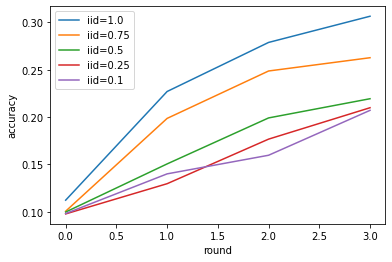

In [34]:
import matplotlib.pyplot as plt

res_iid100 = [0.112375, 0.227, 0.27875, 0.306375]
res_iid75 = [0.10075, 0.198625, 0.248625, 0.262625]
res_iid50 = [0.099875, 0.150625, 0.199125, 0.219375]
res_iid25 = [0.097875, 0.12975, 0.17675, 0.209875]
res_iid10 = [0.09825, 0.140125, 0.15975, 0.207125]

rounds = list(range(4))

# plt.scatter(rounds, res_iid100)
# plt.scatter(rounds, res_iid75)
# plt.scatter(rounds, res_iid50)
# plt.scatter(rounds, res_iid25)
# plt.scatter(rounds, res_iid10)

plt.plot(rounds, res_iid100, label="iid=1.0")
plt.plot(rounds, res_iid75, label="iid=0.75")
plt.plot(rounds, res_iid50, label="iid=0.5")
plt.plot(rounds, res_iid25, label="iid=0.25")
plt.plot(rounds, res_iid10, label="iid=0.1")
plt.xlabel("round")
plt.ylabel("accuracy")
plt.legend(loc="upper left")
plt.show()